In [32]:
import numpy as np
import pandas as pd
import pickle
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from matplotlib import pyplot as plt
import os 
from functions import *
from enrichment import *
from matplotlib_venn import venn2, venn3
from dna_features_viewer import GraphicFeature, GraphicRecord
from scipy import stats

# Load dataset

In [2]:
S = pd.read_csv('../data/IMdata/S.csv')
S = pd.read_csv('../data/IMdata/S.csv',index_col=0)
A = pd.read_csv('../data/IMdata/A.csv',index_col=0)
all_genes = list(S.index)
log_rpkm_norm = pd.read_csv('../data/IMdata/log_rpkm_norm.csv', index_col=0)
log_rpkm = pd.read_csv('../data/IMdata/log_rpkm.csv',index_col=0)
IM_list = list(S.columns)

regulons = load_pickle('../data/IMdata/lpwcfs1_regulons.pkl')
regulators, gene_ids = [],[]
for k in regulons.keys():
    gene_ids += regulons[k]
    regulators += [ k for i in range(len(regulons[k])) ]
trn = pd.DataFrame(zip(regulators,gene_ids), columns=['regulator','gene_id'])

In [3]:
orig_var = (log_rpkm_norm**2).sum().sum()
err_var = ((log_rpkm_norm.values - (S.values).dot(A.values) )**2).sum().sum()
print('Explained variance: {:.2f}'.format(1-err_var/orig_var))

Explained variance: 0.85


# IM gene identification

In [4]:
IM_thersholds = {}
for im in IM_list:
    IM_thersholds[im] = compute_threshold(S, im ,cutoff=550)

In [5]:
# IMs = {}
# for im in IM_list:
#     temp_pd = S[abs(S[im]) >= IM_thersholds[im] ]
#     IMs[im] = list(temp_pd.index)
# dump_pickle(IMs, '../data/IMdata/imodulon_genes.pkl')

In [6]:
IMs = load_pickle('../data/IMdata/imodulon_genes.pkl')

Text(0, 0.5, 'Number')

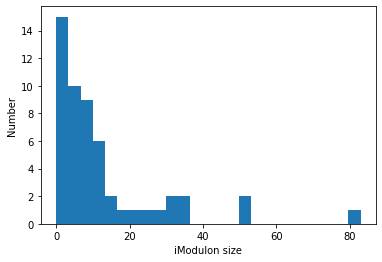

In [7]:
IM_sizes = [len(IMs[im]) for im in IMs]
plt.hist(IM_sizes,bins=25);
plt.xlabel('iModulon size')
plt.ylabel('Number')

# Regulon enrichment

In [8]:
IMwRF = []
for k in IMs:
    if sum(trn.gene_id.isin( IMs[k] ) ) > 0:
        IMwRF.append( k )

In [22]:
compute_trn_enrichment(IMs['16'], list(S.index), trn )

,pvalue,precision,recall,f1score,TP,regulon_size,gene_set_size,n_regs,qvalue


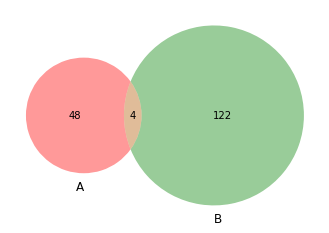

In [16]:
venn2([set(IMs['16']), set(regulons['CcpA'])])

# I-modulon visualization

Text(0, 0.5, 'IM 1 coeff')

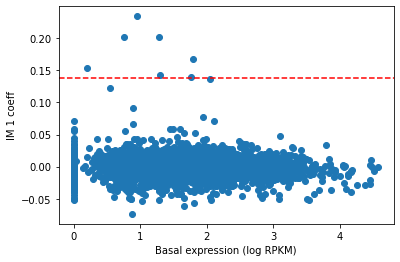

In [9]:
plt.scatter(log_rpkm[['wt_pH6.2_1','wt_pH6.2_2']].mean(axis=1), S['1'] )
plt.axhline(y=IM_thersholds['1'], color='r', linestyle='--' )
plt.xlabel('Basal expression (log RPKM)')
plt.ylabel('IM 1 coeff')

Text(0, 0.5, 'IM 16 coeff')

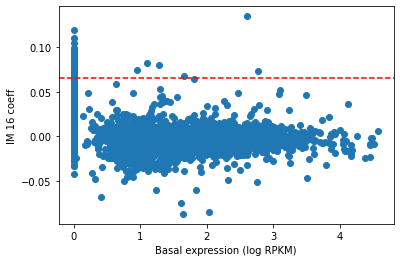

In [23]:
plt.scatter(log_rpkm[['wt_pH6.2_1','wt_pH6.2_2']].mean(axis=1), S['16'] )
plt.axhline(y=IM_thersholds['16'], color='r', linestyle='--' )
plt.xlabel('Basal expression (log RPKM)')
plt.ylabel('IM 16 coeff')

In [25]:
len(IMs['16'])

52

# IM-1 case study

In [9]:
gb_features = pd.read_csv('../data/genome/GCA_000203855.3_ASM20385v3_feature_table.txt',sep='\t')
gb_features = (gb_features[gb_features['# feature']=='gene']).reset_index().drop(['index'],axis=1)
gb_features = gb_features[['start','end','strand','feature_interval_length','symbol','locus_tag']]
gb_features = ( gb_features.dropna(subset=['locus_tag']) ).reset_index().drop(['index'],axis=1)
gb_features['symbol'] = gb_features['symbol'].fillna(gb_features['locus_tag'])
gb_features.head()

,start,end,strand,feature_interval_length,symbol,locus_tag
0,1,1368,+,1368,dnaA,lp_0001
1,1546,2685,+,1140,dnaN,lp_0002
2,3210,3443,+,234,lp_0004,lp_0004
3,3444,4568,+,1125,recF,lp_0005
4,4565,6511,+,1947,gyrB,lp_0006


In [10]:
ref_features = pd.read_csv('../data/genome/GCF_000203855.3_ASM20385v3_feature_table.txt',sep='\t')
ref_features = ( ref_features[ref_features['# feature']=='gene']).reset_index().drop(['index'],axis=1)
ref_features = ref_features[['start','end','strand','feature_interval_length','symbol','attributes']]
ref_features = ( ref_features.dropna(subset=['attributes']) ).reset_index().drop(['index'],axis=1)
locus_tag=[]
for i in range(len(ref_features.index)):
    att = list(ref_features['attributes'])[i]
    if 'old_locus_tag=' in str( att ):
        locus_tag.append( str(att.split('=')[1]).strip()  )
    else:
        locus_tag.append('-')
ref_features['locus_tag']=locus_tag
ref_features = ref_features.drop(['attributes'], axis=1)
ref_features['symbol'] = ref_features['symbol'].fillna(ref_features['locus_tag'])
ref_features.head()

,start,end,strand,feature_interval_length,symbol,locus_tag
0,1,1368,+,1368,dnaA,lp_0001
1,1546,2685,+,1140,dnaN,lp_0002
2,3210,3443,+,234,yaaA,lp_0004
3,3444,4568,+,1125,recF,lp_0005
4,4565,6511,+,1947,gyrB,lp_0006


In [11]:
def save_dict_fasta( seq_dict, out_path ):
    records = []
    for k in seq_dict:
        records.append( SeqRecord(Seq(seq_dict[k]), id = k, name="",description="") )
    SeqIO.write(records, out_path ,"fasta")

In [12]:
im1_promoters=get_im_promoters(IMs['1'], '../data/genome/sequence.fna', gb_features, ref_features)
# save_dict_fasta( im1_promoters, '../data/MEME_results/im1_promoters.fasta' )

# IM-16 case study

In [43]:
im16_promoters=get_im_promoters(IMs['16'], '../data/genome/sequence.fna', gb_features, ref_features)
# save_dict_fasta( im16_promoters, '../data/MEME_results/im16_promoters.fasta' )